<a href="https://colab.research.google.com/github/tangQAQ/LSTM_training/blob/main/Final(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy
from sklearn.model_selection import train_test_split
class data_process:
  def __init__(self):
    pass
    
  # Make the split data and slice sequences at the same time
  def split_sequences(self, data, slice_size, sequences):
    train, val = train_test_split(data, train_size = slice_size, shuffle = False)

    X_train, y_train = self.create_sequences(train, sequences)
    X_val, y_val = self.create_sequences(val, sequences)
    return X_train, y_train, X_val, y_val 

  # Slice sequences with a independent function
  def create_sequences(self, data, sequences):
    X = []
    y = []
    for i in range(sequences, len(data)):
        X.append(data.iloc[i-sequences:i, :])
        y.append(data.iloc[i, :])
    X = numpy.array(X)
    y = numpy.array(y)
    return X, y

In [ ]:
import pandas

class read_process:
  def __init__(self):
    pass
  
  # The data that we craw values are string so here make it be float32 data type
  def read_process(self, data):
    data = data.drop(['Date'], axis=1)
    data = data.apply(lambda x: pd.to_numeric(x.str.replace(',',''), errors='coerce')).fillna(-1).astype('float32')
    return data
  
  # We are making the features for classification with pct_change values that refer to the Close column
  def feature(self, data):
    data['Pct_change'] = data['Close'].pct_change()
    data.drop(data.index[0], inplace=True)
    data['feature_check'] = data['Pct_change'].round(2)*100
    data['feature'] = data['feature_check'].apply(self.replace_values)
    return data

  # Here is the detector that make feature into 22 features that range between -11 and 11 
  def replace_values(self, x):
    if x < -10:
      return -11
    elif x > 10:
      return 11
    elif x >= 0 and x <=1 :
      return 1
    elif x < 0 and x >= -1:
      return -1
    else:
      return x

In [3]:
import matplotlib.pyplot as plt

  # Start with the keras model we using the Sequential to combine the layers first
  # For the layers design we are using 4 LSTM layers for the TimeSeries for each 64 units
  # And last make a dense layer to compress the column to the OneHotencoder shape
  # In this model we choose Adam and categorical_crossentropy for optimizer and loss_function
  # When the model training here take accuracy for metrics
  # We hope the model won't be overfitting so we take a callback for EarlyStopping to monitor the loss and val_loss
  # At last take a history to make a graph to watch the loss and accuracy in both of train and validation 

class Model_patten:
  def __init__(self, X_train, y_train, X_val, y_val):
        self.model = Sequential()
        self.model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        self.model.add(LSTM(units=64, return_sequences=True))
        self.model.add(LSTM(units=64, return_sequences=True))
        self.model.add(LSTM(units=64, return_sequences=False))
        self.model.add(Dense(units=X_train.shape[2], activation='softmax'))
        self.model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='accuracy')
        callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        self.history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[callback])

  def get_loss(self):
    plt.plot(self.history.history['loss'])
    plt.plot(self.history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

  def get_acc(self):
    plt.plot(self.history.history['accuracy'])
    plt.plot(self.history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
 
  def predict(self, X_test):
    return self.model.predict(X_test)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy
import pandas

# For the model preprocessing we take the OneHotEncoder for the features
# Here is fit_transform the train data and transform test data then decode the predict values
class OHEncoder:
  def __init__(self):
    self.enc = None

  def Encoder(self, data):
    data_copy = data.copy()
    enc = OneHotEncoder(sparse=False)
    one_hot = enc.fit_transform(data_copy.values.reshape(-1, 1))
    one_hot_df = pandas.DataFrame(one_hot)
    self.enc = enc
    return one_hot_df

  def transform(self, data):
    transform = self.enc.transform(data.values.reshape(-1, 1))
    tr = pandas.DataFrame(transform)
    return tr

  def Decoder(self, data):
    data_dec = numpy.eye(data.shape[1])[data.argmax(axis=1)]
    return self.enc.inverse_transform(data_dec)

In [4]:
import matplotlib.pyplot as plt

# For compare the predict values with Actual values we make a graph that
# xlabel : Time line
# ylabel : Pct_change (Cause our feature has 22 columns so here make a ylimit that watching much more easier)
# For the red line is Actual Feature and the blue line is Predicted Feature 

class PlotGraph:
    def __init__(self):
        pass
    
    def predict_graph(self, result, actual, timestep):
        plt.figure(figsize=(12, 8))
        plt.title(f'Actual vs. Predicted Pct_change Prices(Timestep {timestep})')
        plt.xlabel('Time line')
        plt.ylabel('Pct_change')
        plt.plot(result, label='Predicted Feature', color='b', linestyle='--')
        plt.plot(actual, label='Actual Feature', color='r')
        plt.ylim([-12, 12])
        plt.legend()
        plt.show()

In [ ]:
# import side
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from google.colab import drive
import warnings 

warnings.filterwarnings('ignore')

In [ ]:
# Reading data and turn into dataframe 
drive.mount('/content/gdrive')
train_data = pd.read_csv("/content/gdrive/MyDrive/GSPC_train.csv")
test_df = pd.read_csv("/content/gdrive/MyDrive/GSPC_test.csv")
Actual_data = pd.read_csv("/content/gdrive/MyDrive/GSPC_Actual.csv")
total = pd.concat((train_data, test_df), axis=0)

# Cause the web crawler has some trouble so before the preprocess data we need to convert the value type first
# Then make the feature with pct_change
rp = read_process()
train = rp.read_process(total)
train_feature = rp.feature(train)
A_d = rp.read_process(Actual_data)
Actual_feature = rp.feature(A_d)

# Here start preprocessing with OneHotEncoder for the feature column
enc_7 = OHEncoder()
enc_15 = OHEncoder()
enc_30 = OHEncoder()

ohe_7 = enc_7.Encoder(train_feature['feature'])
ohe_15 = enc_15.Encoder(train_feature['feature'])
ohe_30 = enc_30.Encoder(train_feature['feature'])

# After transform the feature to OneHotEncoder we are going to make the train, validation split and slice the Timestep to sequences
dp = data_process()
X_train_7, y_train_7, X_val_7, y_val_7 = dp.split_sequences(ohe_7, 0.8, 7)
X_train_15, y_train_15, X_val_15, y_val_15 = dp.split_sequences(ohe_15, 0.8, 15)
X_train_30, y_train_30, X_val_30, y_val_30 = dp.split_sequences(ohe_30, 0.8, 30)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Epoch 1/50
599/599 [==============================] - 21s 13ms/step - loss: 1.0467 - accuracy: 0.6995 - val_loss: 0.9603 - val_accuracy: 0.7092
Epoch 2/50
599/599 [==============================] - 7s 12ms/step - loss: 0.9682 - accuracy: 0.7005 - val_loss: 0.9528 - val_accuracy: 0.7092
Epoch 3/50
599/599 [==============================] - 6s 10ms/step - loss: 0.9625 - accuracy: 0.7005 - val_loss: 0.9533 - val_accuracy: 0.7092
Epoch 4/50
599/599 [==============================] - 7s 12ms/step - loss: 0.9590 - accuracy: 0.7005 - val_loss: 0.9580 - val_accuracy: 0.7092
Epoch 5/50
599/599 [==============================] - 6s 10ms/step - loss: 0.9566 - accuracy: 0.7006 - val_loss: 0.9507 - val_accuracy: 0.7092
Epoch 6/50
599/599 [==============================] - 7s 12ms/step - loss: 0.9547 - accuracy: 0.7006 - val_loss: 0.9491 - val_accuracy: 0.7092
Epoch 7/50
599/599 [==============================] - 6s 10ms/step - loss: 0.9545 - accuracy: 0.7004 - val_loss: 0.9511 - val_accuracy: 0.709

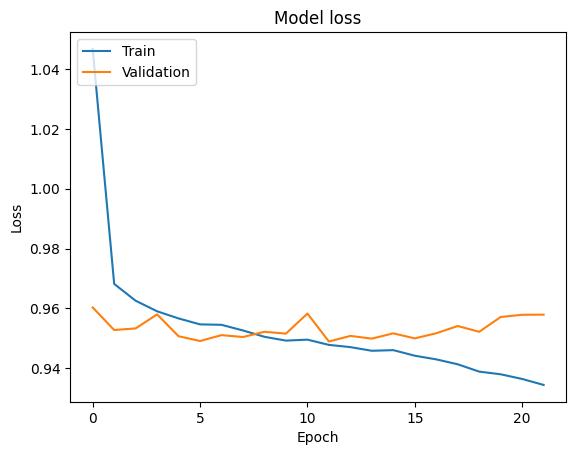

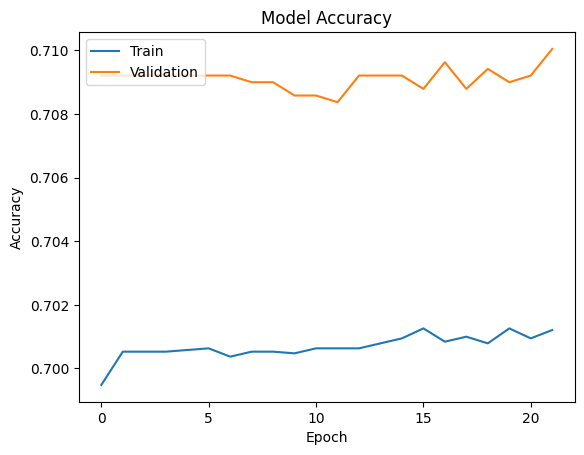

In [ ]:
# Now we start training the model and watch loss and accuracy with graphs to compare model fitting train and validation
model_7 = Model_patten(X_train_7, y_train_7, X_val_7, y_val_7)
model_7.get_loss()
model_7.get_acc()

Epoch 1/50
598/598 [==============================] - 16s 14ms/step - loss: 1.0287 - accuracy: 0.6992 - val_loss: 0.9704 - val_accuracy: 0.7089
Epoch 2/50
598/598 [==============================] - 8s 13ms/step - loss: 0.9601 - accuracy: 0.7004 - val_loss: 0.9621 - val_accuracy: 0.7089
Epoch 3/50
598/598 [==============================] - 8s 13ms/step - loss: 0.9503 - accuracy: 0.7005 - val_loss: 0.9516 - val_accuracy: 0.7089
Epoch 4/50
598/598 [==============================] - 7s 13ms/step - loss: 0.9478 - accuracy: 0.7004 - val_loss: 0.9564 - val_accuracy: 0.7089
Epoch 5/50
598/598 [==============================] - 8s 14ms/step - loss: 0.9443 - accuracy: 0.7005 - val_loss: 0.9456 - val_accuracy: 0.7089
Epoch 6/50
598/598 [==============================] - 7s 11ms/step - loss: 0.9435 - accuracy: 0.7005 - val_loss: 0.9454 - val_accuracy: 0.7089
Epoch 7/50
598/598 [==============================] - 8s 13ms/step - loss: 0.9410 - accuracy: 0.7005 - val_loss: 0.9446 - val_accuracy: 0.708

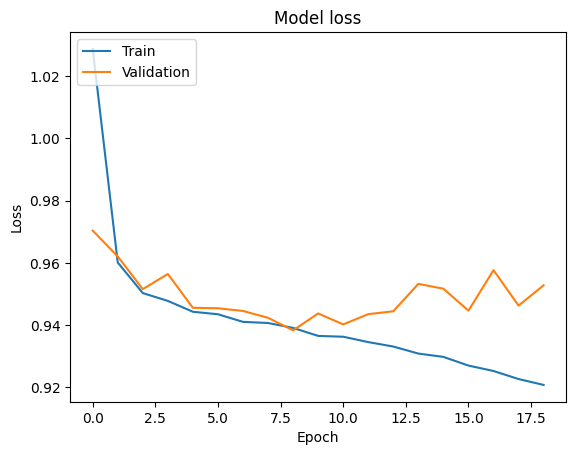

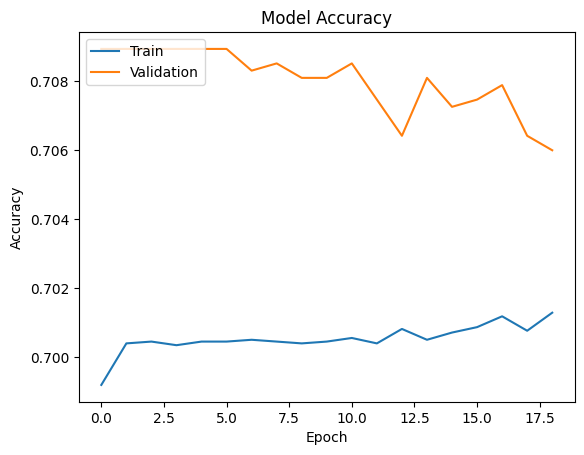

In [ ]:
model_15 = Model_patten(X_train_15, y_train_15, X_val_15, y_val_15)
model_15.get_loss()
model_15.get_acc()

Epoch 1/50
598/598 [==============================] - 18s 16ms/step - loss: 1.0504 - accuracy: 0.6992 - val_loss: 0.9955 - val_accuracy: 0.7095
Epoch 2/50
598/598 [==============================] - 9s 15ms/step - loss: 0.9640 - accuracy: 0.7004 - val_loss: 0.9621 - val_accuracy: 0.7095
Epoch 3/50
598/598 [==============================] - 8s 14ms/step - loss: 0.9511 - accuracy: 0.7004 - val_loss: 0.9465 - val_accuracy: 0.7095
Epoch 4/50
598/598 [==============================] - 8s 14ms/step - loss: 0.9466 - accuracy: 0.7004 - val_loss: 0.9455 - val_accuracy: 0.7095
Epoch 5/50
598/598 [==============================] - 9s 15ms/step - loss: 0.9428 - accuracy: 0.7004 - val_loss: 0.9469 - val_accuracy: 0.7095
Epoch 6/50
598/598 [==============================] - 7s 12ms/step - loss: 0.9411 - accuracy: 0.7004 - val_loss: 0.9396 - val_accuracy: 0.7095
Epoch 7/50
598/598 [==============================] - 8s 14ms/step - loss: 0.9394 - accuracy: 0.7004 - val_loss: 0.9366 - val_accuracy: 0.709

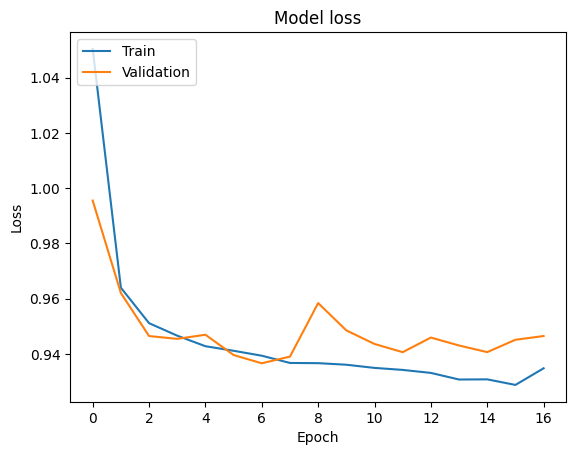

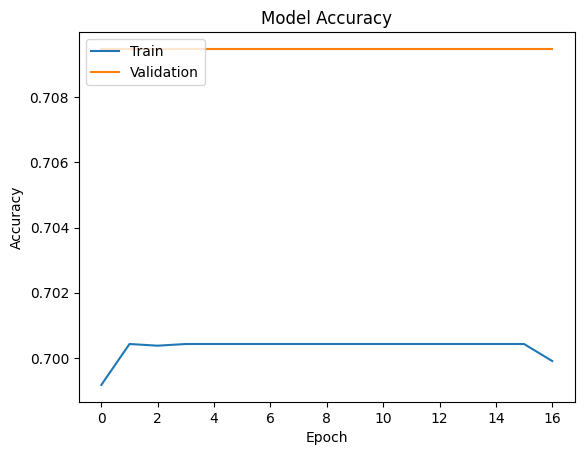

In [ ]:
model_30 = Model_patten(X_train_30, y_train_30, X_val_30, y_val_30)
model_30.get_loss()
model_30.get_acc()

In [ ]:
# Similar to the train data we that the test data to convert and make the feature

test_data_7 = pd.read_csv("/content/gdrive/MyDrive/GSPC_test_7.csv")
test_data_15 = pd.read_csv("/content/gdrive/MyDrive/GSPC_test_15.csv")
test_data_30 = pd.read_csv("/content/gdrive/MyDrive/GSPC_test_30.csv")

test_d7 = rp.read_process(test_data_7)
test_d15 = rp.read_process(test_data_15)
test_d30 = rp.read_process(test_data_30)

test_7 = rp.feature(test_d7)
test_15 = rp.feature(test_d15)
test_30 = rp.feature(test_d30)

In [ ]:
# Here use the specific OneHotEncoder that we defined for the Timestep range to transform the test data
test_enc_7 = enc_7.transform(test_7['feature'])
test_enc_15 = enc_15.transform(test_15['feature'])
test_enc_30 = enc_30.transform(test_30['feature'])

# Then we slice the range Timestep to sequences
X_test_7, y_test_7 = dp.create_sequences(test_enc_7, 7)
X_test_15, y_test_15 = dp.create_sequences(test_enc_15, 15)
X_test_30, y_test_30 = dp.create_sequences(test_enc_30, 30)

# Now we are going to predict the value in our model
test_pred_7 = model_7.predict(X_test_7)
test_pred_15 = model_15.predict(X_test_15)
test_pred_30 = model_30.predict(X_test_30)

# After the predicted values here we decode the OneHotEncoder that the same transform we use
inverse_7 = enc_7.Decoder(test_pred_7)
inverse_15 = enc_15.Decoder(test_pred_15)
inverse_30 = enc_30.Decoder(test_pred_30)

1/1 [==============================] - 1s 1s/step


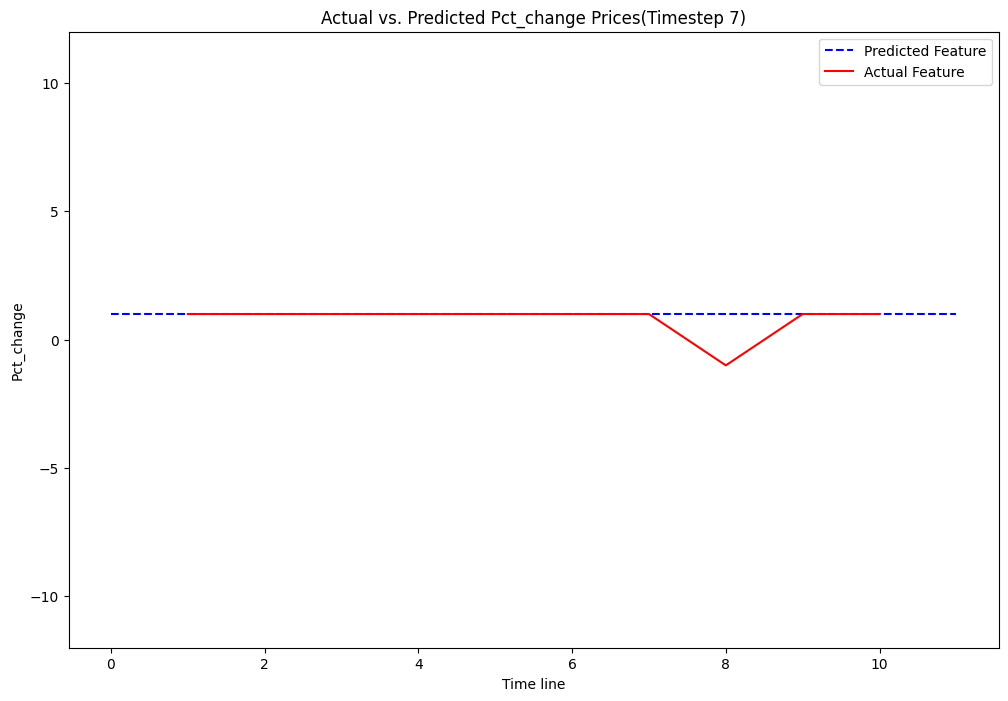

In [ ]:
# Last make a graph to look the predict in our model and compare the actual happened
pg = PlotGraph()
pg.predict_graph(inverse_7, Actual_feature['feature'], 7)

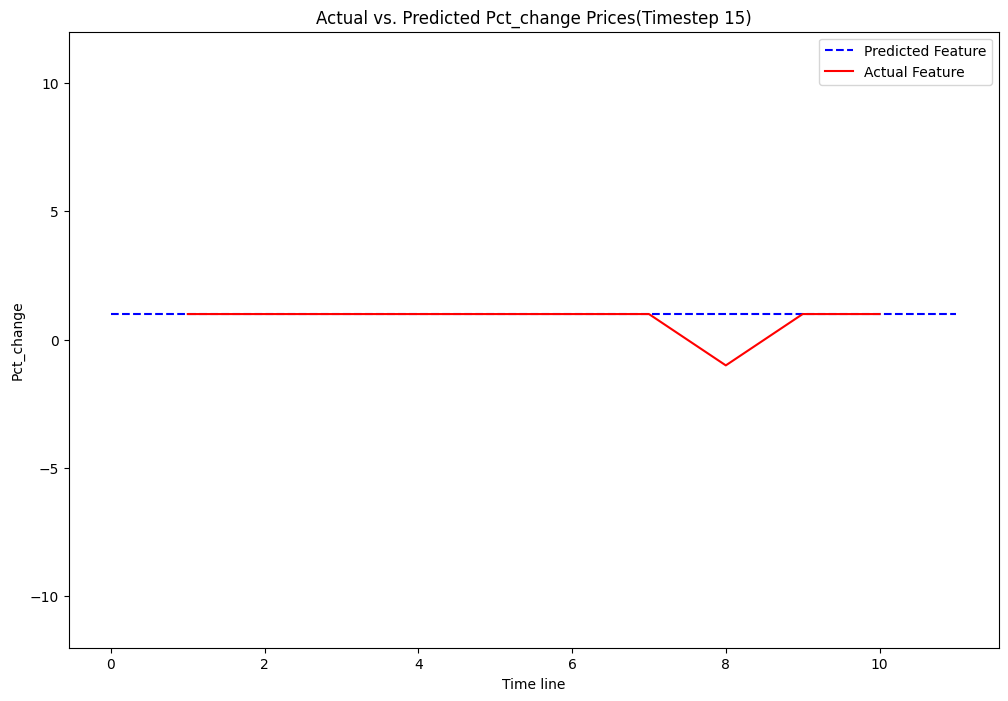

In [ ]:
pg.predict_graph(inverse_15, Actual_feature['feature'], 15)

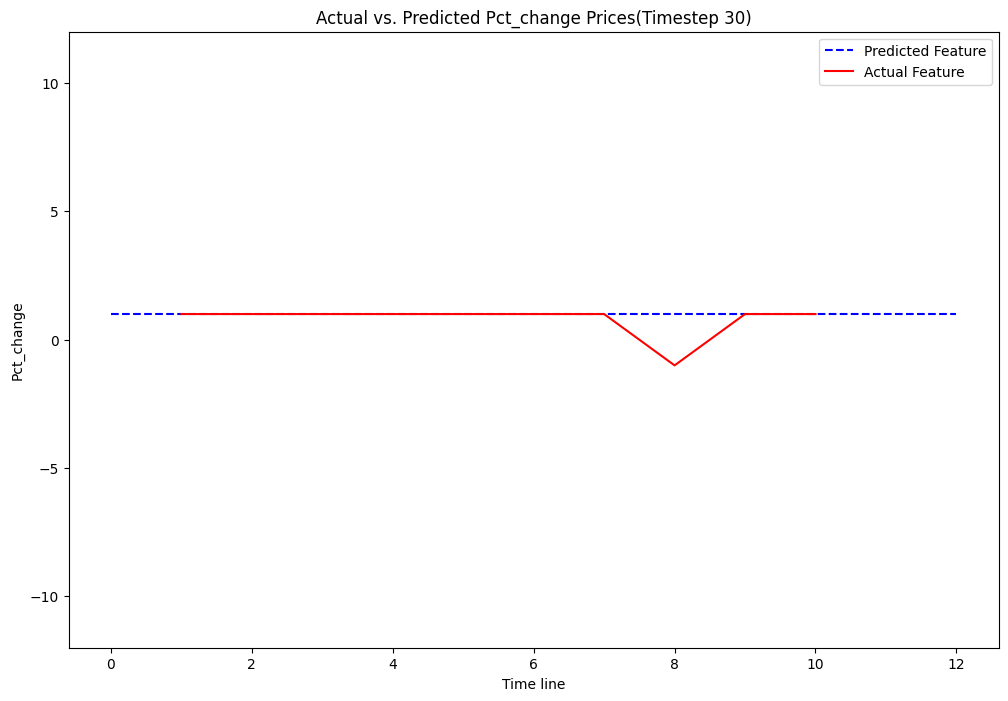

In [ ]:
pg.predict_graph(inverse_30, Actual_feature['feature'], 30)